In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\programminglanguages\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\programminglanguages\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\programminglanguages\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\programminglanguages\python.exe -m pip install --upgrade pip' command.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\programminglanguages\python.exe -m pip install --upgrade pip' command.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from numpy.random import randn
import seaborn as sns
from scipy import stats

%matplotlib inline

In [7]:
import os
import os.path

Загрузим данные о шахматных встречах из csv файла

In [8]:
train = pd.read_csv('./games.csv')
test = pd.read_csv('./test.csv')

просмотрим количество строк и колонок для количественной оценки данных

In [9]:
train.shape

(19959, 16)

просмотрим наименования колонок с которыми будем работать

In [10]:
train.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

Просмотрим первые строки для оценки типов данных и их наличия

In [11]:
train.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,OIyTAHCP,True,1.504190e+12,1.504190e+12,62,resign,white,15+0,avelez8,1734,ars01,1748,d4 d5 c4 Nf6 Nc3 dxc4 e3 Be6 Nf3 a6 b3 cxb3 ax...,D06,Queen's Gambit Refused: Marshall Defense,4
1,bnCnIJSz,True,1.503540e+12,1.503550e+12,101,resign,white,10+0,salah04,1942,avelez8,1739,e4 e6 d4 d5 Nc3 c5 exd5 exd5 Nf3 Nc6 Bb5 Nf6 O...,C10,French Defense: Marshall Variation,6
2,ZzWyY1f8,True,1.503540e+12,1.503540e+12,75,outoftime,white,10+0,avelez8,1724,vincenzo2000,1855,e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Ne5 Nc3 Bb4 Bd2 Nf6...,C45,Scotch Game,7
3,mkKSL3Ev,True,1.503540e+12,1.503540e+12,135,mate,white,10+0,majid_alsalhi,1951,avelez8,1729,e4 e6 d4 d5 e5 c5 c3 Qb6 Nf3 Nc6 a3 Bd7 Be2 Be...,C02,French Defense: Advance Variation | Main Line,11
4,aVwWNjNR,True,1.503540e+12,1.503540e+12,81,outoftime,white,10+0,avelez8,1726,pavankumarg,1388,e4 e5 Nf3 d6 d4 Nc6 dxe5 dxe5 Qxd8+ Kxd8 Bb5 B...,C41,Philidor Defense,5


В данной модели нас интересует влияние очков рейтинга на исход встречи

Для этого создадим поля для численной оценки:
1) rate_difference которое описывает модуль разности рейтинга игроков(колонка созданна для того чтобы была возможность оценить встречи по разнице играющих, что безусловно можно делать и без данной колонки, вычисляя на каждом этапе данное число)
2) winner_rate_difference которое описывает разность рейтинга победителя(колонка созданна для того чтобы была возможность оценить исход встречи при заданной разности рейтинга игроков, что безусловно можно делать и без данной колонки, вычисляя на каждом этапе данное число)
3) численная оценка честности матча(так как необходимых оценок встреч среди данных нет, було решено основываясь на личном опыте игры в шахматы создать колонку численной оценки встречи, при разнице рейтинга более чем в 100 очков зачастую победить не представляется возможным)

и посмотрим на получившиеся данные

In [12]:
train['rate_difference'] = np.abs(train['white_rating'] - train['black_rating'])
train['winner_rate_difference'] = train.apply(lambda x: ((x['white_rating'] - x['black_rating'] if x['winner'] == 'white' else x['black_rating'] - x['white_rating']) if x['winner'] != 'draw' else 0), axis=1)
train['game_qual'] = train.apply(lambda x: (int(x['winner_rate_difference'] / 10) if (abs(x['winner_rate_difference']) / 10) <= 9 else 9 ), axis=1)
X_train = train.drop(labels=['winner'], axis=1).copy()
Y_train = train['winner'].values.copy()
train.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,rate_difference,winner_rate_difference,game_qual
0,OIyTAHCP,True,1.504190e+12,1.504190e+12,62,resign,white,15+0,avelez8,1734,ars01,1748,d4 d5 c4 Nf6 Nc3 dxc4 e3 Be6 Nf3 a6 b3 cxb3 ax...,D06,Queen's Gambit Refused: Marshall Defense,4,14,-14,-1
1,bnCnIJSz,True,1.503540e+12,1.503550e+12,101,resign,white,10+0,salah04,1942,avelez8,1739,e4 e6 d4 d5 Nc3 c5 exd5 exd5 Nf3 Nc6 Bb5 Nf6 O...,C10,French Defense: Marshall Variation,6,203,203,9
2,ZzWyY1f8,True,1.503540e+12,1.503540e+12,75,outoftime,white,10+0,avelez8,1724,vincenzo2000,1855,e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Ne5 Nc3 Bb4 Bd2 Nf6...,C45,Scotch Game,7,131,-131,9
3,mkKSL3Ev,True,1.503540e+12,1.503540e+12,135,mate,white,10+0,majid_alsalhi,1951,avelez8,1729,e4 e6 d4 d5 e5 c5 c3 Qb6 Nf3 Nc6 a3 Bd7 Be2 Be...,C02,French Defense: Advance Variation | Main Line,11,222,222,9
4,aVwWNjNR,True,1.503540e+12,1.503540e+12,81,outoftime,white,10+0,avelez8,1726,pavankumarg,1388,e4 e5 Nf3 d6 d4 Nc6 dxe5 dxe5 Qxd8+ Kxd8 Bb5 B...,C41,Philidor Defense,5,338,338,9


Проверим изменения в количестве данных

In [13]:
X_train.shape, Y_train.shape

((19959, 18), (19959,))

Выведем гистограммы для первичного анализа данных

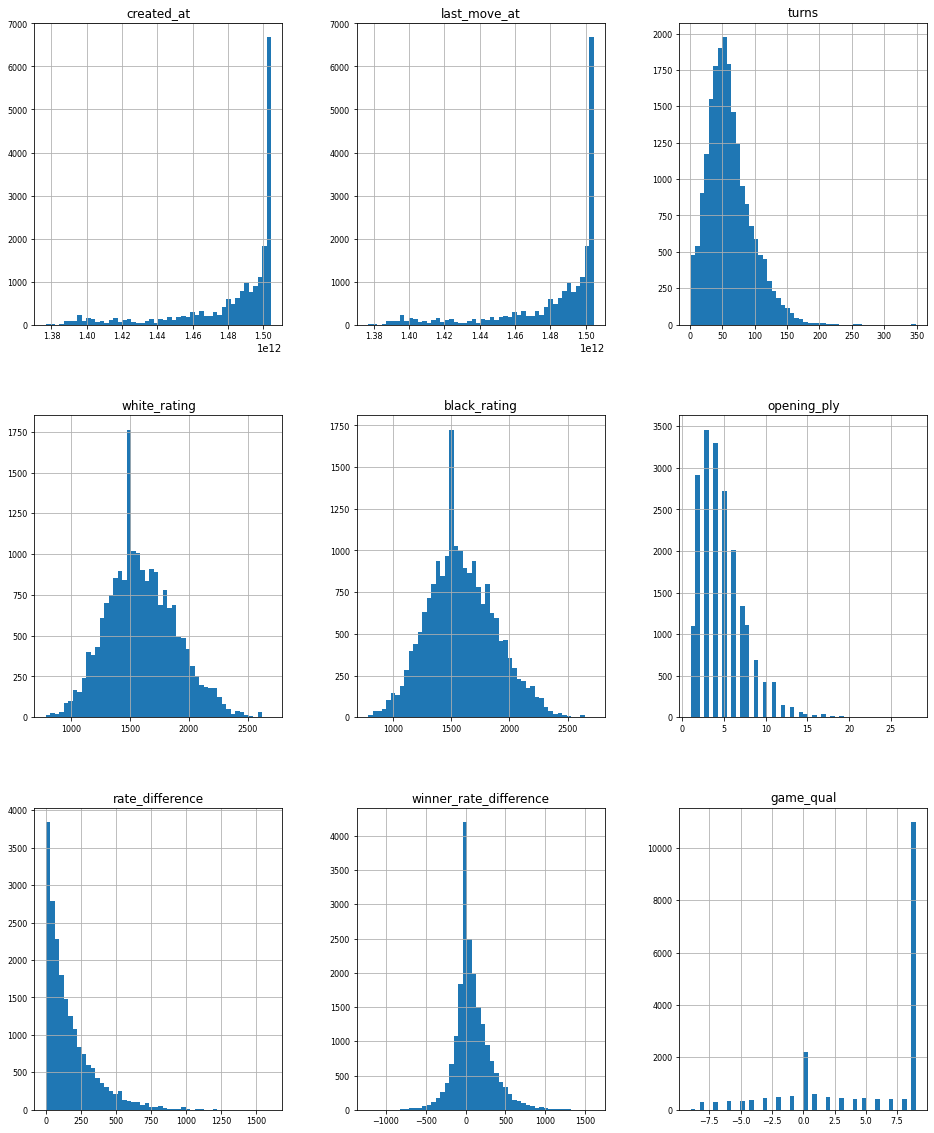

In [14]:
train.hist(figsize=(16, 20), bins=50, xlabelsize=8,ylabelsize=8);

Поскольку мы оцениваем влияние разности рейтинга на исход в стречи то целевой столбец rate_difference

расмотрим детальнее гистограмма по данному столбцу

заметим что ярких явных выбрасов не наблюдается

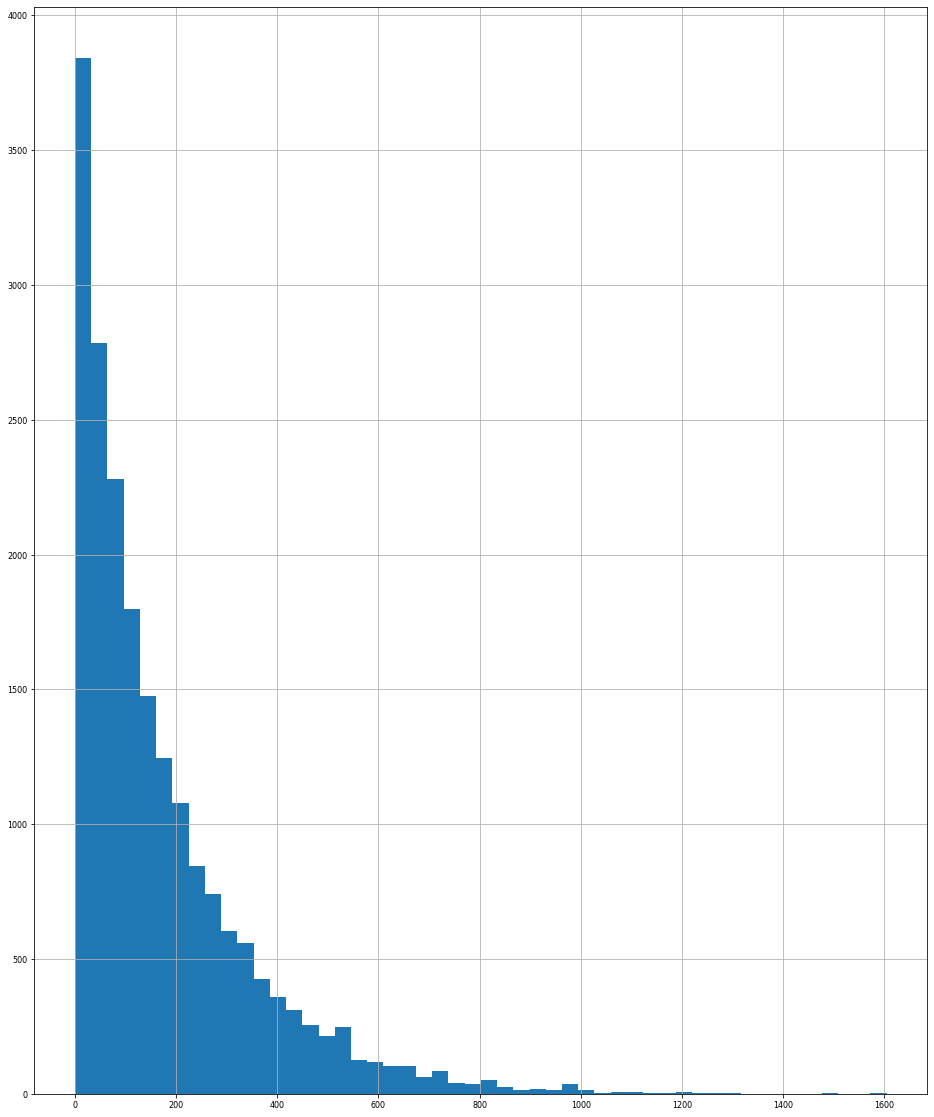

In [15]:
train['rate_difference'].hist(figsize=(16, 20), bins=50, xlabelsize=8,ylabelsize=8);

для дальнейшего анализа построим график rate_difference/winner_rate_difference

и заметим линейность(действительно ведь одни данные состоят из других...)

но нас интересует больше знак этой зависимости, который указывает нам на исход встречи
а также сама разность рейтингов

на данном этапе уже заметны выбросы достаточно странных данных которые указывают что с разностью рейтингов более 100 побеждает менее опытный игрок

а также то что игроки с разницей рейтингов более 100 выходят из встречи в ничью

такие данные исходя из описанного выше считаем выбросами

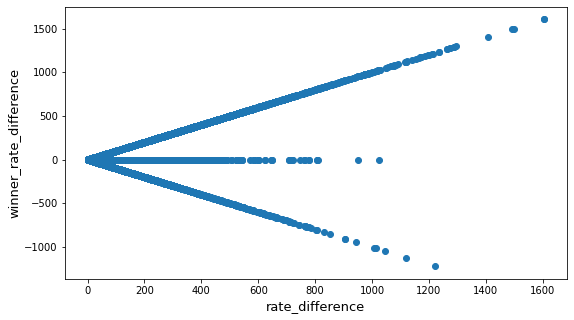

In [16]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x=train['rate_difference'], y=train['winner_rate_difference'])
plt.ylabel('winner_rate_difference', fontsize=13)
plt.xlabel('rate_difference', fontsize=13)
plt.show()

далее расмотрм тот же график но отсечем те данные которые посчитали не валидными на предыдущем этапе

теперь график зависимости результата встречи от разницы рейтинга играющих является более правдоподобным
поскольку как правило людям с рейтингом выше нашего на 100 значительно легче выйграть

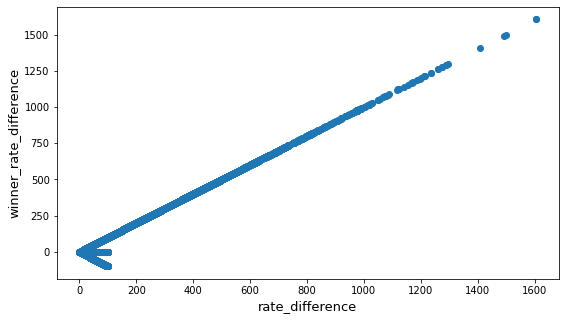

In [17]:
train = train.drop(
    train[
        (
            (train['black_rating'] + 100 < train['white_rating']) & (train['winner'] == 'black')
        ) | 
        (
            (train['black_rating']  > train['white_rating'] + 100) & (train['winner'] == 'white')
        ) |
        (
            (train['rate_difference'] > 100) & (train['winner'] == 'draw')
        )
    ].index
)

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x=train['rate_difference'], y=train['winner_rate_difference'])
plt.ylabel('winner_rate_difference', fontsize=13)
plt.xlabel('rate_difference', fontsize=13)
plt.show()

Далее посмотрим на график оценки к разнице рейтинга(И да не стоит забывать что эти поля имеют 1 общего родителя)

мы видим относительно предметной области хороший график без явных выбросов(что кажется логичным...)

Но обратим внимание на самый яркий столбец, он имеет такой вид ввиду того что в данной предметной области чем больше разность рейтингов тем более легкая победа будет, такой картины в отрицательных значених мы не наблюдаем ввиду того что приняли постфактом, то что победить человеку с рейтингом ниже более чем на 100 очков невозможно(отфильтровали данные выше...)

данный график нас устраивает

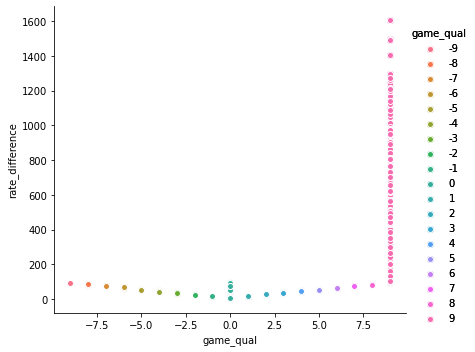

In [18]:
columns = ['rate_difference', 'winner_rate_difference', 'game_qual']

g = sns.FacetGrid(train[columns], hue='game_qual', height=5) \
    .map(plt.scatter, 'game_qual', 'rate_difference') \
    .add_legend()

g = g.map(plt.scatter, 'game_qual', 'rate_difference', edgecolor='w').add_legend()

plt.show()

Графически оценим нормализацию наших данных

исходя из графиков видно, что данные имеют на небольшом участке нормализованный вид, но по большей части нет

d:\programminglanguages\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


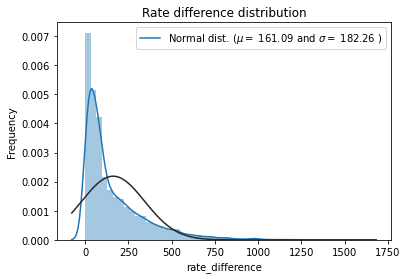

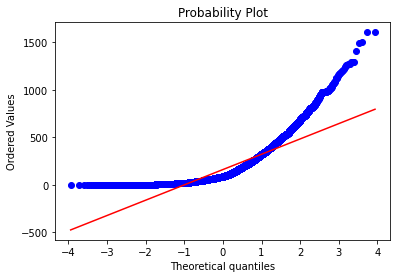

In [19]:
sns.distplot(train['rate_difference'], fit=stats.norm);

(mu, sigma) = stats.norm.fit(train['rate_difference'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rate difference distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['rate_difference'], plot=plt)
plt.show()

Прологарифмируем данные в попытке нормализовать их

In [20]:
train['rate_difference'] = np.log1p(train['rate_difference'])

проверим умеличилась ли протяженность наложения наших графиков

Да увеличилось, что позволяет нам сказать что на данном промежутке наши данные нормализованы
но также мы видим некоторые выбросы... связаны они с набором данных в данном случае из-за наличия игр соперников координально отличающихся по рейтингу, что в обычных играх не встречается

d:\programminglanguages\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


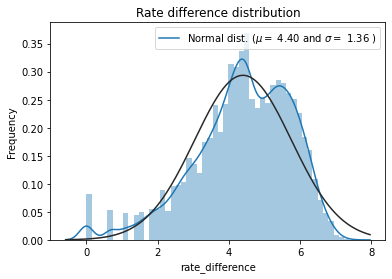

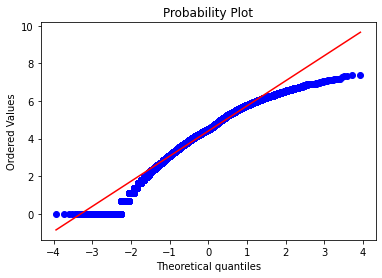

In [21]:
sns.distplot(train['rate_difference'], fit=stats.norm);

(mu, sigma) = stats.norm.fit(train['rate_difference'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rate difference distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['rate_difference'], plot=plt)
plt.show()

Посмотрим на отображение полей друг на друга

Видим их всех взаимосвязь(как и предполагалось)

<Figure size 432x288 with 0 Axes>

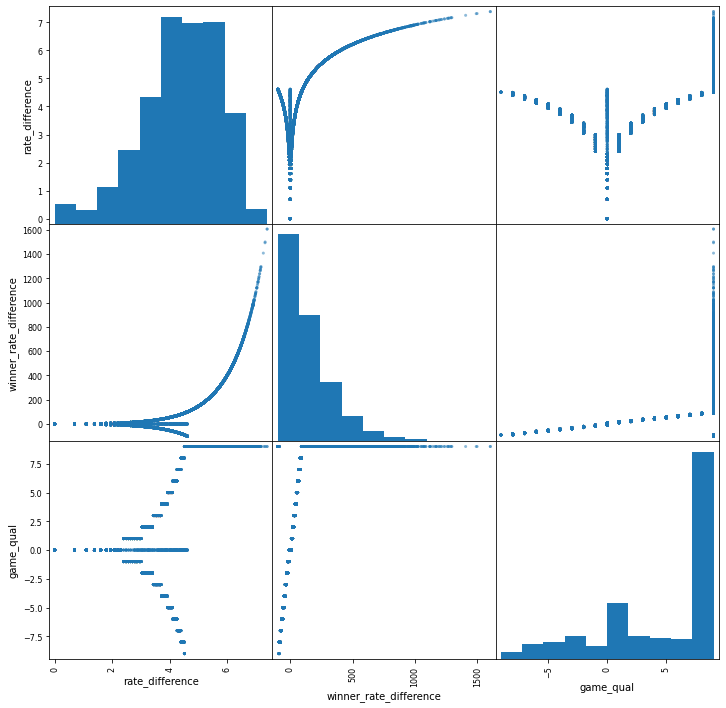

<Figure size 432x288 with 0 Axes>

In [22]:
columns = ['rate_difference', 'winner_rate_difference', 'game_qual']

pd.plotting.scatter_matrix(train[columns], figsize=(12,12))
plt.figure()

Для более точного понимания степени связанности данных построим тепловую карту со коэфицентами связностей

на которой более точно понятно во сколько раз наши данные связанны

<AxesSubplot:>

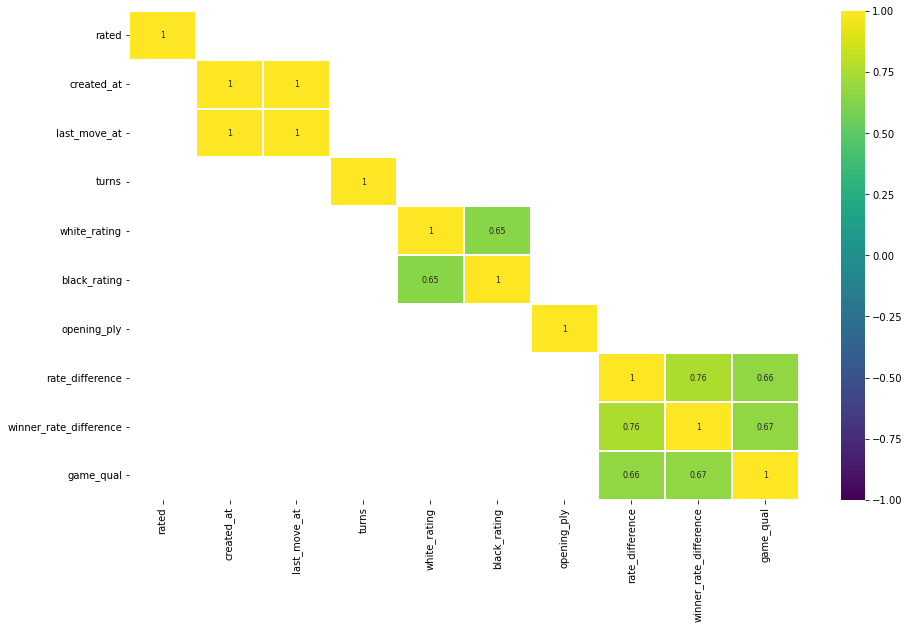

In [23]:
corrmat = train.corr()
plt.subplots(figsize=(15,9))
sns.heatmap(corrmat[(corrmat >= 0.4) | (corrmat < -0.4)], 
            cmap='viridis',
            vmax=1.0, vmin=-1.0,
            linewidth=0.1,
            annot=True,
            annot_kws={"size":8})

Обьеденим тестовые и обучающие данные для дальнейшего анализа

In [24]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.rate_difference.values
all_data = pd.concat((train, test), sort=True).reset_index(drop=True)
all_data.drop(['rate_difference'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (16911, 18)


Посчитаем пропущеные данные

Таковых нет, что логично для этих данных

In [25]:
all_data_na = (train.isnull().sum() / len(train)) * 100
# all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
id,0.0
rated,0.0
created_at,0.0
last_move_at,0.0
turns,0.0


Просмотрим смещение распределения признаков

коэфиценты хоршие)


In [26]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
winner_rate_difference,1.674517
opening_ply,1.324052
turns,0.900971
white_rating,0.306290
black_rating,0.261634
rate_difference,-0.712398
game_qual,-0.791738
rated,-1.673300
last_move_at,-1.804921
created_at,-1.804931


разделим данные обратно на тренировочные и тестовые

In [27]:
train = all_data[:ntrain]
test = all_data[ntrain:]

Хоть и набор данных был выбран не большой и не сложный, но именно это и заставило с ним помучаться-.-